<a href="https://colab.research.google.com/github/PriyankaS8/Covid-19_Predictor/blob/master/Covid_19_Prediction_Using_XceptionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Covid-19 Prediction Using Chest X-ray Image


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
import os
from glob import glob
import json
import os.path as osp
import sys
import math
from PIL import Image
import PIL.ImageDraw
import io
import shutil

Using TensorFlow backend.


In [2]:
keras.__version__

'2.3.1'

In [3]:
tf.__version__

'2.2.0'

In [0]:
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k

In [0]:
# calculate accuracy measures and confusion matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc,roc_curve,classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd "/content/drive/My Drive/covid-predictor_data_folder/"

/content/drive/My Drive/covid-predictor_data_folder


In [0]:
#Define hyperparameter variable which will be used later
img_size=150
nb_classes = 2  # number of classes
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 20  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation

#**1. Data Collection**

In [0]:
#In the GenerateDataSet method collect all image file path from COVID-19 and NORMAL folder and return as dataframe.
#In this dataframe, ImageName has file path and "Class" has label value 0 for NORMAL and 1 for COVID-19.
#Note : PNEUMONIA folder is not in use here
def GenerateDataSet(rootFolder):
    rows_list = []
    listOfFiles = os.listdir(rootFolder)
    for l in listOfFiles:
      if l=="PNEUMONIA":
        continue
      subFolder = rootFolder + "/" + l
      label=0
      if l == "COVID-19":
        label=1
      
      for label_file in glob(osp.join(subFolder, '*.*')):
        rows_list.append({'ImageName':label_file,'Class':label})
      
    return pd.DataFrame(rows_list)

In [0]:
#Get Dataset
df=GenerateDataSet("./Dataset")

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ImageName  463 non-null    object
 1   Class      463 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.4+ KB


In [0]:
df.head()

,ImageName,Class
0,./Dataset/NORMAL/IM-0007-0001.jpeg,0
1,./Dataset/NORMAL/IM-0009-0001.jpeg,0
2,./Dataset/NORMAL/IM-0010-0001.jpeg,0
3,./Dataset/NORMAL/IM-0011-0001-0001.jpeg,0
4,./Dataset/NORMAL/IM-0011-0001-0002.jpeg,0


#**2. Exploratory Data Analysis**



In [0]:
df["Class"].value_counts()

1    233
0    230
Name: Class, dtype: int64

In [0]:
print("Total COVID-19 Class Count : ",df["Class"].value_counts()[1])
print("Total NORMAL Class Count : ",df["Class"].value_counts()[0])

Total COVID-19 Class Count :  233
Total NORMAL Class Count :  230


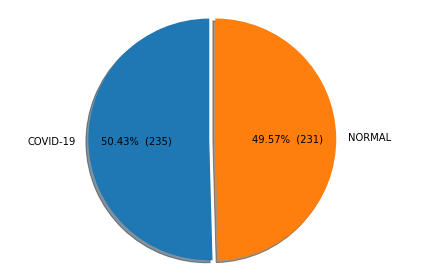

In [0]:
# Pie chart
labels = ['COVID-19', 'NORMAL']
sizes = [235, 231]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.05)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda p:f'{p:.2f}%  ({p*sum(sizes)/100 :.0f})',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()


In [0]:
covid_df=df[df["Class"]==1]
normal_df=df[df["Class"]==0]

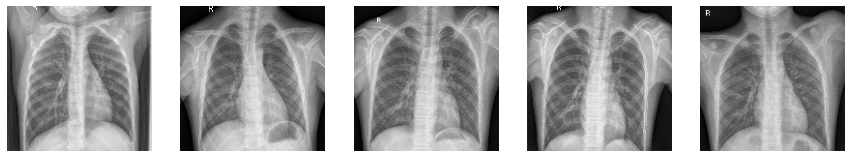

In [0]:
fig=plt.figure(figsize=(15, 15))

columns = 5
rows = 2
for i in range(1, 6):
    img = cv2.imread(normal_df.iloc[i].ImageName)
    img = cv2.resize(img, (img_size, img_size))
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(img)
plt.show()

##Sample picture from Normal patient X-ray Images


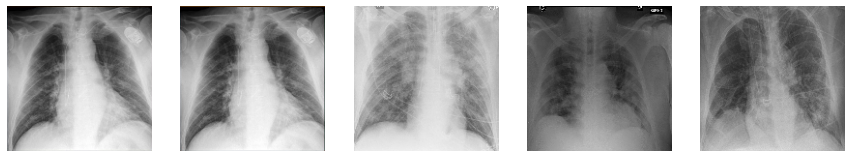

In [0]:
fig=plt.figure(figsize=(15, 15))

columns = 5
rows = 2
for i in range(1, 6):
    img = cv2.imread(covid_df.iloc[i].ImageName)
    img = cv2.resize(img, (img_size, img_size))
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(img)
plt.show()

##Sample picture from COVID-19 positive patient X-ray Images

#3. Data Pre-Processing



In [0]:
msk = np.random.rand(len(df)) < 0.80
train_df = df[msk]
test_df = df[~msk]

In [0]:
train_df.shape

(389, 2)

In [0]:
test_df.shape

(74, 2)

In [0]:
#This method used for pre-proceesing data from dataframe before modelling for Train and same will be used for Validate and Test data set.
#This method return image normalized data in numpy array format as X and corresponding label value in Y.
def imagePreProcess(data):
  X=[]
  Y=[]
  for i in data.itertuples():
    #Read image from physical file using Open CV
    img_arr = cv2.imread(i[1])
    #Resize image bytes to 150x150
    resized_arr = cv2.resize(img_arr, (img_size, img_size))
    X.append(resized_arr)
    Y.append(i[2])
  #Normalize the image data to 0-1 from 0-255 
  X=np.array(X)/255
  return X, np.array(Y)

In [0]:
X,y=imagePreProcess(train_df)

In [0]:
X.shape

(389, 150, 150, 3)

In [0]:
test_size = 0.20 # taking 80:20 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)

In [0]:
X_test,y_test=imagePreProcess(test_df)

In [0]:
print("Total Data Count :",len(df["Class"]))
print("Total Train Data Count :",len(X_train))
print("Total Validation Data Count :",len(X_val))
print("Total Test Data Count :",len(X_test))

Total Data Count : 463
Total Train Data Count : 311
Total Validation Data Count : 78
Total Test Data Count : 74


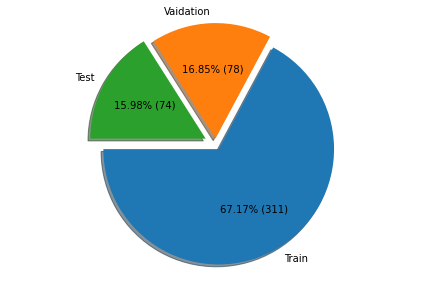

In [0]:
# Pie chart
labels = ['Train','Vaidation', 'Test']
sizes = [len(X_train), len(X_val),len(X_test)]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0.05, 0.05,0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda p:f'{p:.2f}% ({p*sum(sizes)/100 :.0f})',
        shadow=True, startangle=180)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

# **Deep Learning Image Binary Classification Model:**

######Here we will be using Xception model base architecture with transfer learning technique to predict COVID-19

###**Xception Model:**


In [0]:
# Pre-Trained CNN Model using imagenet dataset for pre-trained weights
base_xception_model = Xception(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 2s 0us/step


In [0]:
#Set pre-trained model layers to not trainable
#for layer in base_xception_model.layers:
#layer.trainable = False

In [0]:
# Top Model Block
x = base_xception_model.output
x=Dropout(0.4)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

In [0]:
# add your top layer block to your base model
xception_model = Model(base_xception_model.input, predictions)

In [0]:
xception_model.compile(optimizer='nadam',
              loss='binary_crossentropy',  # categorical_crossentropy if multi-class classifier
              metrics=['accuracy'])

In [0]:
xception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = './xception_CovidVsNormal_Final_Best_model_weights.h5'
callbacks_list = [
    ModelCheckpoint(final_weights_path, verbose=1, save_best_only=True,),
    EarlyStopping(monitor='val_loss', patience=5, verbose=0)
]

In [0]:
# Train the Xception Model for 10 epochs with train and validation data.
#Using callback function we are adding Model checkpoint to save best model in each epoch 
#And doing early stopping the training to stop model overfitting.
xception_history=xception_model.fit(X_train,y_train, 
                                    validation_data=( X_val , y_val ),
                                    epochs=10,
                                    batch_size=batch_size,
                                    callbacks=callbacks_list)

Train on 311 samples, validate on 78 samples
Epoch 1/10
311/311 [==============================] - 142s 457ms/step - loss: 0.2390 - accuracy: 0.9164 - val_loss: 1.6248 - val_accuracy: 0.6154

Epoch 00001: val_loss improved from inf to 1.62480, saving model to ./xception_CovidVsNormal_Final_Best_model_weights.h5
Epoch 2/10
311/311 [==============================] - 128s 412ms/step - loss: 0.0705 - accuracy: 0.9807 - val_loss: 1.0128 - val_accuracy: 0.8077

Epoch 00002: val_loss improved from 1.62480 to 1.01279, saving model to ./xception_CovidVsNormal_Final_Best_model_weights.h5
Epoch 3/10
311/311 [==============================] - 128s 412ms/step - loss: 0.0682 - accuracy: 0.9839 - val_loss: 3.2854 - val_accuracy: 0.6667

Epoch 00003: val_loss did not improve from 1.01279
Epoch 4/10
311/311 [==============================] - 128s 410ms/step - loss: 0.0575 - accuracy: 0.9775 - val_loss: 0.5573 - val_accuracy: 0.9103

Epoch 00004: val_loss improved from 1.01279 to 0.55727, saving model t

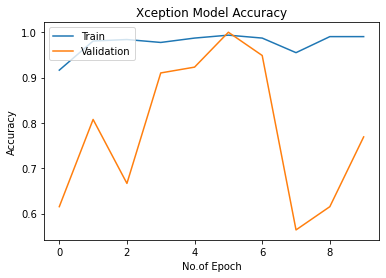

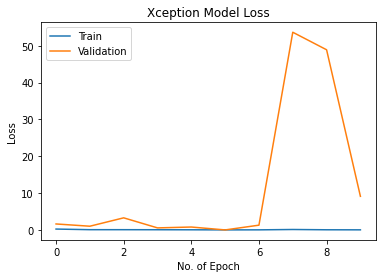

In [0]:
import matplotlib.pyplot as plt
plt.plot(xception_history.history['accuracy'])
plt.plot(xception_history.history['val_accuracy'])
plt.title('Xception Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No.of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(xception_history.history['loss'])
plt.plot(xception_history.history['val_loss'])
plt.title('Xception Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##**Validation Data Prediction**

In [0]:
val_predictions = xception_model.predict(X_val)

In [0]:
predicted_val_result=[]

for i in val_predictions:
  if(i[0] > 0.5):
    predicted_val_result.append(1)
  else:
    predicted_val_result.append(0)

In [0]:
predicted_val_result=np.array(predicted_val_result)

In [0]:
print(classification_report(y_val, predicted_val_result))

              precision    recall  f1-score   support

           0       0.96      0.57      0.72        40
           1       0.69      0.97      0.80        38

    accuracy                           0.77        78
   macro avg       0.82      0.77      0.76        78
weighted avg       0.83      0.77      0.76        78



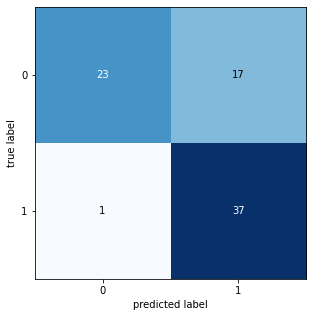

In [0]:
CM = confusion_matrix(y_val, predicted_val_result)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

##**Test Data Prediction**


In [0]:
test_predictions = xception_model.predict(X_test)

In [0]:
predicted_result=[]

for i in test_predictions:
  if(i[0] > 0.5):
    predicted_result.append(1)
  else:
    predicted_result.append(0)

In [0]:
predicted_result=np.array(predicted_result)

In [0]:
print(classification_report(y_test, predicted_result))

              precision    recall  f1-score   support

           0       1.00      0.55      0.71        38
           1       0.68      1.00      0.81        36

    accuracy                           0.77        74
   macro avg       0.84      0.78      0.76        74
weighted avg       0.84      0.77      0.76        74



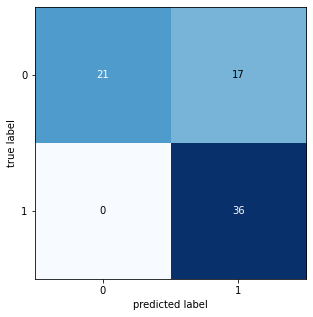

In [0]:
CM = confusion_matrix(y_test, predicted_result)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()